## Community Detection — End-to-End Workflow

This notebook demonstrates unsupervised community detection on a graph.
	•	Data Exploration: load a classic network, inspect structure, visualize
	•	Preprocessing: connected components, matrices, helpers
	•	Modeling: Greedy Modularity (CNM), Spectral Clustering (on adjacency), Girvan–Newman (edge betweenness)
	•	Evaluation: modularity, conductance, (optional) ARI/NMI vs ground truth (Karate Club)

We’ll use Zachary’s Karate Club network, which includes a known split for comparison.

## Setup

In [7]:
# Install required packages into THIS kernel (safe to run multiple times)
import sys, subprocess, importlib

def ensure(pkg_import, pip_name=None):
    pip_name = pip_name or pkg_import
    try:
        importlib.import_module(pkg_import)
        print(f"{pip_name} already installed.")
    except Exception:
        print(f"Installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

ensure("networkx")        

# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from typing import List, Dict, Tuple, Set, Optional
from IPython.display import display

# sklearn for spectral clustering + external clustering metrics
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.8, 4.4)
plt.rcParams["axes.grid"] = False

networkx already installed.


## Data Exploration

We’ll load Zachary’s Karate Club graph. Nodes have an attribute 'club' indicating the historic split (Mr. Hi vs Officer).

Graph: Graph | directed=False | nodes=34 | edges=78 | density=0.1390 | avg_deg=4.59 | connected=True


count    34.000000
mean      4.588235
std       3.877813
min       1.000000
25%       2.000000
50%       3.000000
75%       5.000000
max      17.000000
dtype: float64

Ground-truth counts:
 ground_truth
0    17
1    17
Name: count, dtype: int64


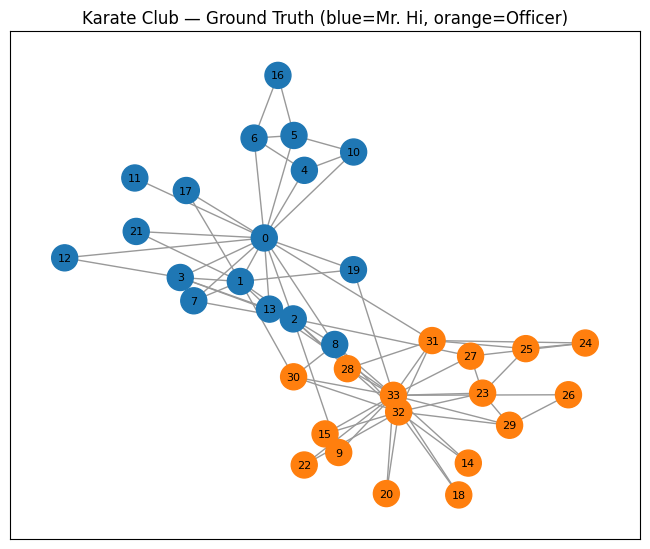

In [8]:
# Load Zachary's Karate Club graph
G = nx.karate_club_graph()

# Summary
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
density = nx.density(G)
avg_deg = np.mean([d for _, d in G.degree()])
is_conn = nx.is_connected(G) if not G.is_directed() else nx.is_weakly_connected(G)

print(
    f"Graph: {G.__class__.__name__} "
    f"| directed={G.is_directed()} "
    f"| nodes={n_nodes} "
    f"| edges={n_edges} "
    f"| density={density:.4f} "
    f"| avg_deg={avg_deg:.2f} "
    f"| connected={is_conn}"
)


# Degree distribution
deg_series = pd.Series(dict(G.degree())).sort_values(ascending=False)
display(deg_series.describe())

# Ground-truth label distribution (binary split)
gt_labels = pd.Series({v: (1 if G.nodes[v]['club'] == 'Officer' else 0) for v in G.nodes()}, name="ground_truth")
print("Ground-truth counts:\n", gt_labels.value_counts())

# Visualize graph with ground-truth colors
pos = nx.spring_layout(G, seed=42)  # fixed positions for repeatability
colors = ['tab:blue' if gt_labels[v] == 0 else 'tab:orange' for v in G.nodes()]
plt.figure(figsize=(6.6, 5.6))
nx.draw_networkx(G, pos=pos, node_color=colors, with_labels=True, node_size=350, font_size=8, edge_color="#999999")
plt.title("Karate Club — Ground Truth (blue=Mr. Hi, orange=Officer)")
plt.tight_layout(); plt.show()

## Preprocessing

We’ll ensure connectivity (Karate is already connected), prepare helpers to convert between labels and community sets, and build an adjacency matrix for spectral clustering.

In [9]:
# Ensure largest connected component (LCC)
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"Graph was disconnected — using LCC with {G.number_of_nodes()} nodes.")

# Node index mapping (stable order)
nodes = sorted(G.nodes())
node_to_idx = {v: i for i, v in enumerate(nodes)}
idx_to_node = {i: v for v, i in node_to_idx.items()}

# Adjacency matrix (numpy array)
A = nx.to_numpy_array(G, nodelist=nodes)  # symmetric

# Helpers: partition <-> labels
def labels_to_partition(labels: np.ndarray, nodes_order: List[int]) -> List[Set[int]]:
    """Group node indices by label -> list of node sets (as original node ids)."""
    labs = np.asarray(labels)
    parts = []
    for k in np.unique(labs):
        idxs = np.where(labs == k)[0]
        parts.append(set(nodes_order[i] for i in idxs))
    return parts

def partition_to_labels(partition: List[Set[int]], nodes_order: List[int]) -> np.ndarray:
    """Turn a list of node sets into a label array aligned to nodes_order."""
    lab = np.zeros(len(nodes_order), dtype=int)
    for cid, comm in enumerate(partition):
        for v in comm:
            lab[node_to_idx[v]] = cid
    return lab

## Modeling

We’ll run three community detection methods:
	1.	Greedy Modularity (Clauset–Newman–Moore) — fast heuristic that maximizes modularity
	2.	Spectral Clustering — run on the adjacency as precomputed affinity (we’ll pick the best k by modularity)
	3.	Girvan–Newman — edge betweenness hierarchical split (we’ll cut to a chosen number of communities)

In [10]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity

# 1) Greedy Modularity (CNM)
cnm_comms = list(greedy_modularity_communities(G))  # list of frozensets of nodes
cnm_partition = [set(c) for c in cnm_comms]
cnm_labels = partition_to_labels(cnm_partition, nodes)
print(f"Greedy Modularity found {len(cnm_partition)} communities.")

# 2) Spectral Clustering on adjacency (choose k by modularity)
best_spec = {"k": None, "labels": None, "partition": None, "modularity": -np.inf}
for k in range(2, 6):  # small sweep for this small graph
    spec = SpectralClustering(
        n_clusters=k, affinity='precomputed', assign_labels='kmeans',
        random_state=42
    )
    y_spec = spec.fit_predict(A)  # labels in [0..k-1] aligned to nodes[]
    part_spec = labels_to_partition(y_spec, nodes)
    Q = modularity(G, part_spec)
    if Q > best_spec["modularity"]:
        best_spec = {"k": k, "labels": y_spec, "partition": part_spec, "modularity": Q}
print(f"Spectral best k={best_spec['k']} with modularity={best_spec['modularity']:.4f}")

# 3) Girvan–Newman (cut at k communities)
def girvan_newman_k(G: nx.Graph, k: int) -> List[Set[int]]:
    """Run GN until k communities are formed, return partition as list[set]."""
    comp = girvan_newman(G)
    for _ in range(k - 1):
        communities = next(comp)
    return [set(c) for c in communities]

gn_k = 2  # Karate split is famously ~2
gn_partition = girvan_newman_k(G, k=gn_k)
gn_labels = partition_to_labels(gn_partition, nodes)
print(f"Girvan–Newman cut at k={gn_k} produced {len(gn_partition)} communities.")

Greedy Modularity found 3 communities.
Spectral best k=4 with modularity=0.4449
Girvan–Newman cut at k=2 produced 2 communities.


## Evaluation

Primary unsupervised metric is modularity Q. We also show mean conductance (lower is better).
Because Karate has ground truth, we’ll compute ARI and NMI vs the known split.

In [11]:
from networkx.algorithms.cuts import conductance

def mean_conductance(G: nx.Graph, partition: List[Set[int]]) -> float:
    vals = []
    for comm in partition:
        if 0 < len(comm) < G.number_of_nodes():
            vals.append(conductance(G, comm))
    return float(np.mean(vals)) if vals else np.nan

def eval_partition(name: str, labels: np.ndarray, partition: List[Set[int]]) -> Dict[str, float]:
    Q = modularity(G, partition)
    mcond = mean_conductance(G, partition)
    # External metrics (need ground truth)
    y_true = gt_labels.loc[nodes].to_numpy()
    # Align labels to consecutive ints for fair ARI/NMI
    y_pred = labels.astype(int)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"Communities: {len(partition)} | Modularity: {Q:.4f} | Mean conductance: {mcond:.4f}")
    print(f"ARI vs GT: {ari:.4f} | NMI vs GT: {nmi:.4f}")
    return {"k": len(partition), "modularity": Q, "mean_conductance": mcond, "ARI": ari, "NMI": nmi}

metrics = {}
metrics["Greedy Modularity (CNM)"] = eval_partition("Greedy Modularity (CNM)", cnm_labels, cnm_partition)
metrics[f"Spectral (k={best_spec['k']})"] = eval_partition(f"Spectral (k={best_spec['k']})", best_spec["labels"], best_spec["partition"])
metrics[f"Girvan–Newman (k=2)"] = eval_partition("Girvan–Newman (k=2)", gn_labels, gn_partition)

display(pd.DataFrame(metrics).T.sort_values("modularity", ascending=False))


=== Greedy Modularity (CNM) ===
Communities: 3 | Modularity: 0.4110 | Mean conductance: 0.2808
ARI vs GT: 0.5684 | NMI vs GT: 0.5646

=== Spectral (k=4) ===
Communities: 4 | Modularity: 0.4449 | Mean conductance: 0.2875
ARI vs GT: 0.4646 | NMI vs GT: 0.5878

=== Girvan–Newman (k=2) ===
Communities: 2 | Modularity: 0.3477 | Mean conductance: 0.1515
ARI vs GT: 0.7717 | NMI vs GT: 0.7324


,k,modularity,mean_conductance,ARI,NMI
Spectral (k=4),4.0,0.444904,0.287500,0.464591,0.587850
Greedy Modularity (CNM),3.0,0.410965,0.280830,0.568439,0.564607
Girvan–Newman (k=2),2.0,0.347660,0.151515,0.771725,0.732378


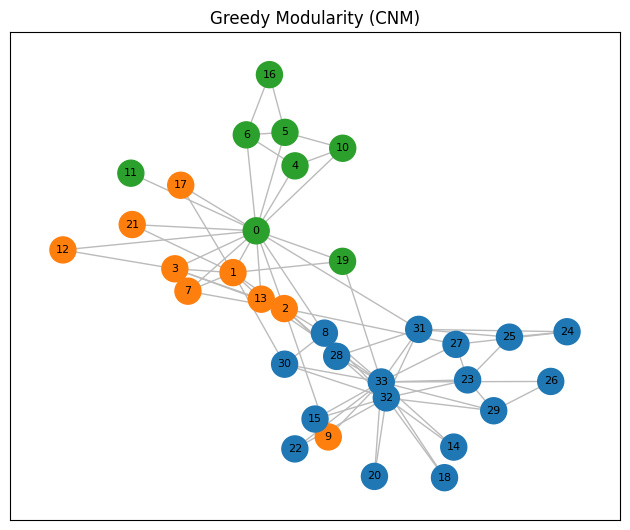

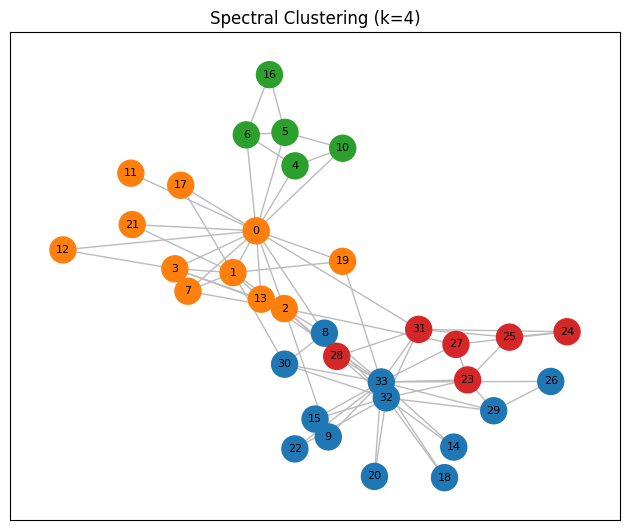

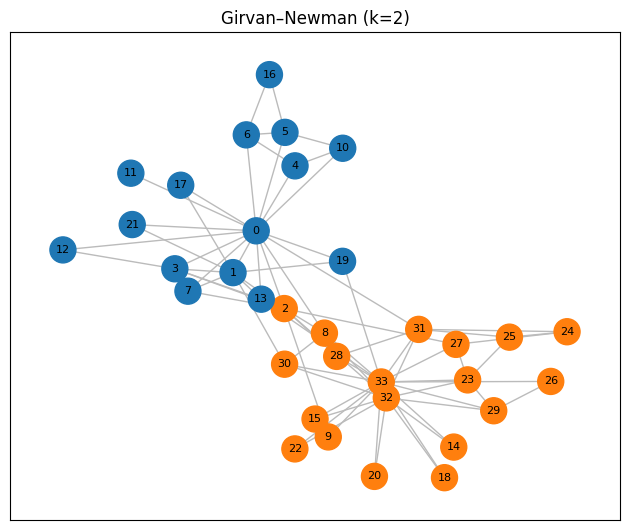

In [12]:
# Visualize each method's partitioning
def draw_partition(G, pos, partition: List[Set[int]], title: str):
    # Assign a color per community
    import itertools
    # simple color cycle
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['tab:blue','tab:orange','tab:green','tab:red']))
    node_colors = {}
    for comm, color in zip(partition, color_cycle):
        for v in comm:
            node_colors[v] = color
    c = [node_colors[v] for v in G.nodes()]
    plt.figure(figsize=(6.4, 5.4))
    nx.draw_networkx(G, pos=pos, node_color=c, with_labels=True, node_size=350, font_size=8, edge_color="#bbbbbb")
    plt.title(title)
    plt.tight_layout(); plt.show()

draw_partition(G, pos, cnm_partition, "Greedy Modularity (CNM)")
draw_partition(G, pos, best_spec["partition"], f"Spectral Clustering (k={best_spec['k']})")
draw_partition(G, pos, gn_partition, "Girvan–Newman (k=2)")

## Key Takeaways
	•	Community Detection finds groups of nodes with dense intra-group and sparse inter-group connections.
	•	Modularity is a common objective/metric (higher is better), but beware resolution limits (small communities can be missed).
	•	Greedy Modularity is fast and often strong; Girvan–Newman is informative but slow; Spectral requires choosing k (we used modularity to pick it).
	•	When ground truth exists (rare), check ARI/NMI in addition to modularity.